In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# Load dataset
file_path = "/Users/adaguan/Desktop/HopSkipDrive_Take_Home/boost_df.csv"
df = pd.read_csv(file_path)

### Exploratory Data Analysis

In [3]:
# Display dataset info
print("Dataset Info:")
print(df.info())

# Show first few rows
print("\nFirst Few Rows:")
print(df.head())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Summary statistics for numerical columns
print("\nSummary Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21861 entries, 0 to 21860
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   trip_id                                  21861 non-null  int64  
 1   cumulative_boost_amount_cents            21861 non-null  float64
 2   boost_timestamp                          11861 non-null  object 
 3   manual_boost                             21861 non-null  int64  
 4   boost_ind                                21861 non-null  int64  
 5   seq_boost_count                          21861 non-null  int64  
 6   single_boost_amount_cents                21861 non-null  float64
 7   trip_state                               21861 non-null  object 
 8   created_at                               21861 non-null  object 
 9   claimed_at                               21861 non-null  object 
 10  scheduled_starts_at             

In [4]:
# Check for duplicate trip_id
duplicate_trips = df.duplicated(subset=['trip_id']).sum()
print(f"Duplicate trip IDs: {duplicate_trips}")

Duplicate trip IDs: 4361


In [5]:
# Display some duplicate trip_id records
duplicate_rows = df[df.duplicated(subset=['trip_id'], keep=False)]
print(duplicate_rows.head(10))  # Show first 10 duplicate rows

# Count how many unique trip_id values exist
unique_trip_count = df["trip_id"].nunique()
total_trip_count = len(df)

print(f"Total Trips: {total_trip_count}")
print(f"Unique Trips: {unique_trip_count}")
print(f"Duplicate Trip Count: {total_trip_count - unique_trip_count}")

    trip_id  cumulative_boost_amount_cents      boost_timestamp  manual_boost  \
1        58                          492.1  2024-05-29 14:10:23             1   
2        58                          877.1  2024-05-29 14:37:26             1   
35      752                         1403.5  2024-05-16 13:56:06             1   
36      752                         1893.5  2024-05-16 14:04:17             1   
37      752                         2383.5  2024-05-16 14:16:08             1   
39      806                         1722.0  2024-05-14 13:32:06             1   
40      806                         2212.0  2024-05-14 13:43:10             1   
41      808                         1687.0  2024-05-20 13:32:06             1   
42      808                         2142.0  2024-05-20 13:42:17             1   
43      808                         2597.0  2024-05-20 13:52:15             1   

    boost_ind  seq_boost_count  single_boost_amount_cents trip_state  \
1           1                1      

Some trips appear multiple times (trip_id duplicates exist).
Columns like cumulative_boost_amount_cents, boost_timestamp, seq_boost_count differ, meaning these are not exact duplicates but rather different records for the same trip.

In [6]:
# Convert timestamp columns to datetime format
datetime_cols = ["boost_timestamp", "created_at", "claimed_at", 
                 "scheduled_starts_at", "scheduled_ends_at", 
                 "unclaimed_at", "trip_completed_at"]
for col in datetime_cols:
    df[col] = pd.to_datetime(df[col])

# Verify conversion
print(df.dtypes)

trip_id                                             int64
cumulative_boost_amount_cents                     float64
boost_timestamp                            datetime64[ns]
manual_boost                                        int64
boost_ind                                           int64
seq_boost_count                                     int64
single_boost_amount_cents                         float64
trip_state                                         object
created_at                                 datetime64[ns]
claimed_at                                 datetime64[ns]
scheduled_starts_at                        datetime64[ns]
scheduled_ends_at                          datetime64[ns]
unclaimed_at                               datetime64[ns]
trip_completed_at                          datetime64[ns]
total_predicted_duration_mins                     float64
total_predicted_distance_miles                    float64
total_predicted_distance_miles_for_fare           float64
dollars_paid_t

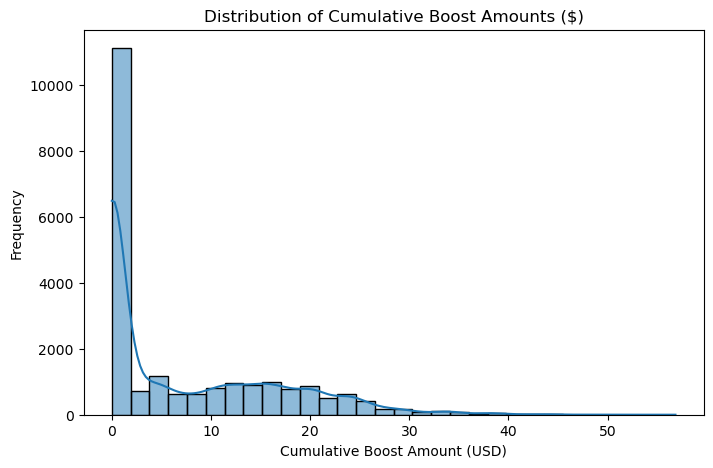

In [7]:
# Distribution of Boost Amounts
plt.figure(figsize=(8,5))
sns.histplot(df["cumulative_boost_amount_cents"] / 100, bins=30, kde=True)
plt.title("Distribution of Cumulative Boost Amounts ($)")
plt.xlabel("Cumulative Boost Amount (USD)")
plt.ylabel("Frequency")
plt.show()

### Key Insights (Distribution of Cumulative Boost Amounts)
#### 1. Most rides receive low boosts
- The highest concentration of rides has very small or zero boosts.
- A steep drop-off after the first bar suggests that a small portion of rides receive higher boosts.

#### 2. Long Tail Distribution
- Some rides receive significantly high boost amounts, but they are less frequent.
- This suggests that higher boosts may only be used in specific cases (e.g., hard-to-fill rides).

#### 3. Potential Opportunity for Cost Optimization
- Since most rides are claimed with low or no boost, it might be possible to reduce excessive boosts without delaying ride claims.

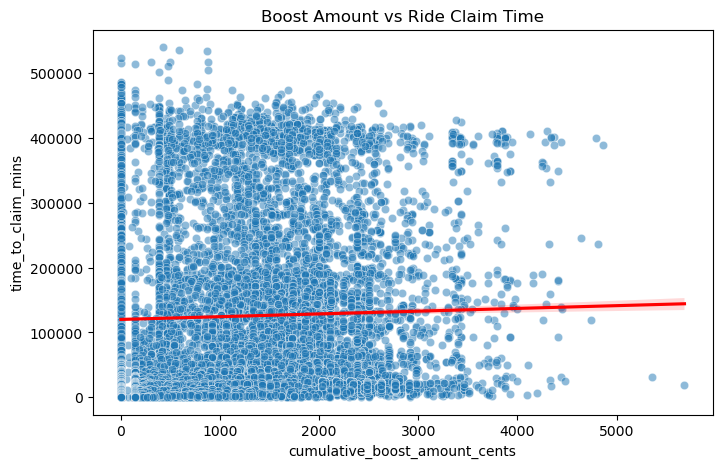

Correlation between Boost Amount and Claim Time: 0.03


In [8]:
# Calculate time to claim in minutes
df["time_to_claim_mins"] = (df["claimed_at"] - df["created_at"]).dt.total_seconds() / 60

# Scatter plot: Boost Amount vs. Time to Claim
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x="cumulative_boost_amount_cents", y="time_to_claim_mins", alpha=0.5)
plt.title("Boost Amount vs Ride Claim Time")
plt.xlabel("Cumulative Boost Amount (Cents)")
plt.ylabel("Time to Claim (Minutes)")

# Add a trend line (linear regression)
sns.regplot(x='cumulative_boost_amount_cents', y='time_to_claim_mins', data=df, scatter=False, color='red')
plt.show()

# Correlation coefficient
correlation = df["cumulative_boost_amount_cents"].corr(df["time_to_claim_mins"])
print(f"Correlation between Boost Amount and Claim Time: {correlation:.2f}")

### Key Insights (Boost Amount vs Ride Claim Time)

#### Negative Trend:  
The graph shows a general tendency for the time to claim to decrease as the cumulative boost amount increases.  This makes intuitive sense: larger boosts likely provide a stronger incentive to claim the reward quickly. However, the relationship is noisy, suggesting other factors are at play.

#### Clustering at Low Boosts and Fast Claims:  
The dense cluster of points near the origin (0,0) indicates that many trips have small or no boosts and are claimed very quickly.  These might represent users who are highly engaged and would have claimed promptly regardless of a boost.

#### Spread and Variability:  
As the boost amount increases, the spread of the data points along the y-axis (time to claim) also increases.  This means that for higher boost amounts, the time to claim becomes much more variable.  This suggests that boosts are not the only factor influencing claim time.  Other factors likely play a role.

#### Potential Diminishing Returns:  
The decrease in claim time doesn't appear to be directly proportional to the increase in boost amount.  The biggest drop in claim time seems to occur at relatively low boost amounts.  Beyond a certain point, increasing the boost amount might not have as dramatic an effect on reducing claim time.  This hints at the possibility of diminishing returns.

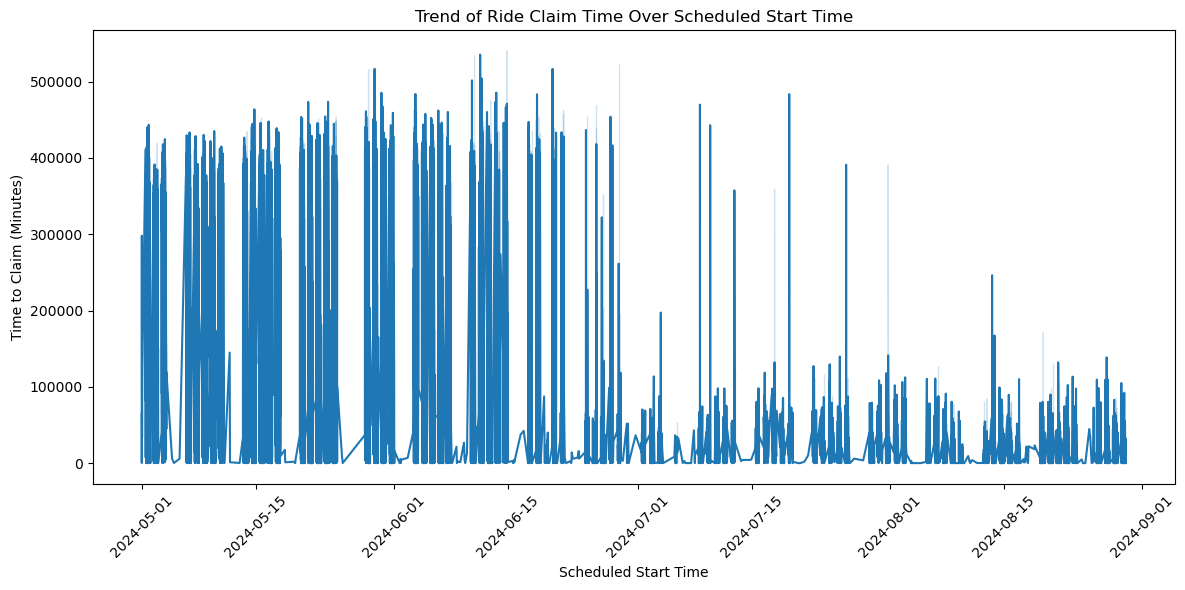

In [9]:
# Ride Claim Trend Over Time
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="scheduled_starts_at", y=(df["claimed_at"] - df["created_at"]).dt.total_seconds()/60)
plt.title("Trend of Ride Claim Time Over Scheduled Start Time")
plt.xlabel("Scheduled Start Time")
plt.ylabel("Time to Claim (Minutes)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Key Insights (Trend of Ride Claim Over Time)

#### High Variability in Claim Times: 
The most striking feature is the extreme variability in the time it takes for rides to be claimed.  The peaks and valleys in the line plot indicate that claim times can fluctuate dramatically from day to day.

#### Potential Cyclical Patterns:  
While not definitively clear, there's a suggestion of some cyclical patterns.  Peaks and troughs can be seen roughly every few weeks. This could indicate weekly or monthly cycles related to rider demand, driver availability, or other factors.  However, more data would be needed to confirm any true seasonality.

#### General Trend:  
While there are fluctuations, there doesn't seem to be a strong overall upward or downward trend in claim times across the four-month period.  The variability is the dominant characteristic.

#### Questions:
- Demand: How did rider demand fluctuate over this period?
- Driver Supply: Were there changes in the number of available drivers?
- External Events: Were there any holidays, weather events, or other external factors that could have affected claim times?
- Promotions: Were there any promotions or incentives offered during this period?